100%|██████████| 5.00G/5.00G [02:48<00:00, 29.6MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 194MB/s]
<ipython-input-1-098b6d66f252>:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda'

Epoch 01/50 | Train Loss: 4.3600 | Train Acc: 0.0545 | Val Loss: 3.9527 | Val Acc: 0.1248 | Time: 178.1s
✅ Saved best model with val_acc=0.1248
Epoch 02/50 | Train Loss: 4.0484 | Train Acc: 0.1169 | Val Loss: 3.6342 | Val Acc: 0.2000 | Time: 176.5s
✅ Saved best model with val_acc=0.2000
Epoch 03/50 | Train Loss: 3.8533 | Train Acc: 0.1589 | Val Loss: 3.4163 | Val Acc: 0.2488 | Time: 177.2s
✅ Saved best model with val_acc=0.2488
Epoch 04/50 | Train Loss: 3.7014 | Train Acc: 0.1934 | Val Loss: 3.2313 | Val Acc: 0.2943 | Time: 177.6s
✅ Saved best model with val_acc=0.2943
Epoch 05/50 | Train Loss: 3.5744 | Train Acc: 0.2234 | Val Loss: 3.0895 | Val Acc: 0.3324 | Time: 176.3s
✅ Saved best model with val_acc=0.3324
Epoch 06/50 | Train Loss: 3.4725 | Train Acc: 0.2495 | Val Loss: 2.9711 | Val Acc: 0.3679 | Time: 176.8s
✅ Saved best model with val_acc=0.3679
Epoch 07/50 | Train Loss: 3.3841 | Train Acc: 0.2696 | Val Loss: 2.8710 | Val Acc: 0.3911 | Time: 176.7s
✅ Saved best model with val_acc

<ipython-input-1-098b6d66f252>:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Predicted class: 63


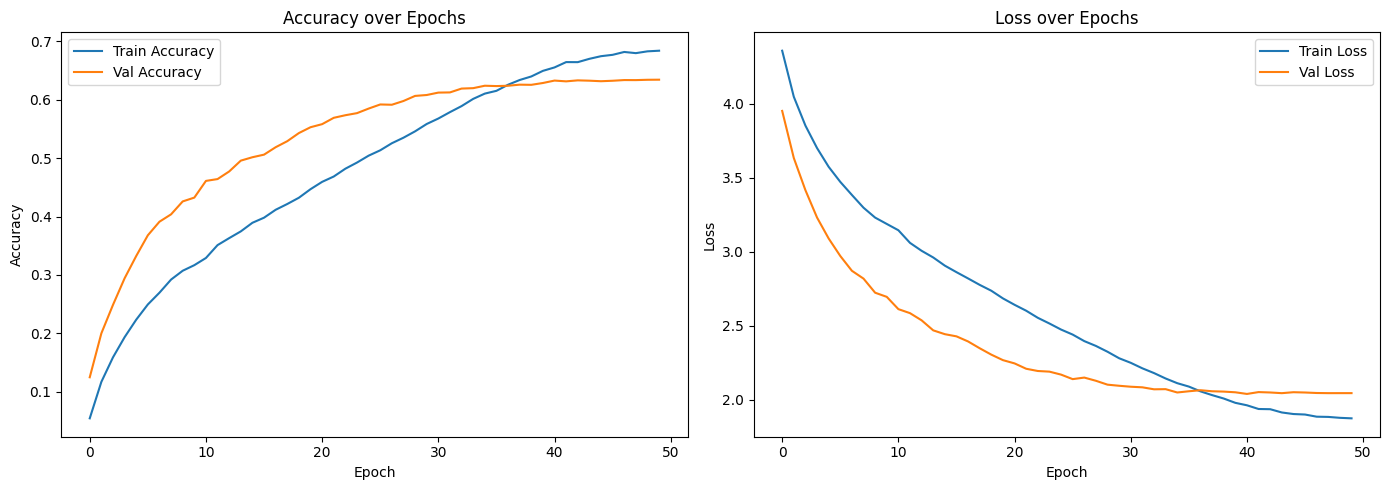

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import Food101
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
import os
import time

# ====== CONFIGURATION ======
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
NUM_CLASSES = 101
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "models/vit_best_food101.pth"
os.makedirs("models", exist_ok=True)

# ====== DATA TRANSFORMS ======
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ====== DATA LOADERS ======
train_data = Food101(root='./data', split='train', download=True, transform=train_transform)
val_data = Food101(root='./data', split='test', download=True, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ====== MODEL SETUP ======
model = models.vit_b_16(pretrained=True)
model.heads = nn.Linear(model.heads[0].in_features, NUM_CLASSES)
model.to(DEVICE)

# ====== OPTIMIZER, LOSS, SCHEDULER ======
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = GradScaler()

# ====== TRAINING FUNCTION ======
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total, correct, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total += labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)

    return total_loss / total, correct / total

# ====== VALIDATION FUNCTION ======
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)

    return total_loss / total, correct / total

import matplotlib.pyplot as plt

# ====== LOGGING STORAGE ======
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ====== TRAINING LOOP ======
best_acc = 0.0
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Time: {time.time() - start_time:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✅ Saved best model with val_acc={val_acc:.4f}")

# ====== PLOT AND SAVE TRAINING CURVES ======
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("training_plot.png")
print("📈 Saved training plot as training_plot.png")


# ====== FINAL PREDICTION EXAMPLE ======
model.eval()
for img, label in val_loader:
    img = img[0].unsqueeze(0).to(DEVICE)
    with torch.no_grad(), autocast():
        logits = model(img)
    print("Predicted class:", logits.argmax(1).item())
    break


In [ ]:
from torchvision.datasets import Food101
class_names = Food101(root='./data', download=True).classes

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 1. Define model architecture and load weights
num_classes = 101
model = models.vit_b_16(pretrained=False)
model.heads = nn.Linear(model.heads[0].in_features, num_classes)
model.load_state_dict(torch.load("vit_best_food101.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Define transform (must match training!)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 3. Load and preprocess image
image_path = "taco.jpeg"  # Change this to your test image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# 4. Make prediction
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

print("Predicted class index:", predicted_class)
from torchvision.datasets import Food101
class_names = Food101(root='./data', download=True).classes
print("Predicted class name:", class_names[predicted_class])

Predicted class index: 90
Predicted class name: spaghetti_bolognese
